In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [14]:
#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

#7种情绪 angry, disgust, fear, happy, sad, surprise, neutral
num_classes = 7
batch_size = 256
epochs = 5

In [15]:
with open("./fer2013/fer2013.csv") as f:
    content = f.readlines()
lines = np.array(content)
num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))
#48*48=2304

number of instances:  35888
instance length:  2304


In [16]:
#初始化测试和训练集
x_train, y_train, x_test, y_test = [], [], [], []
for i in range(1,num_of_instances):
    emotion, img, usage = lines[i].split(",")
    val = img.split(" ")
    pixels = np.array(val, 'float32')
    emotion = keras.utils.to_categorical(emotion, num_classes)
    if 'Training' in usage:
        y_train.append(emotion)
        x_train.append(pixels)
    elif 'PublicTest' in usage:
        y_test.append(emotion)
        x_test.append(pixels)
        
#转np.array
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

#归一化处理
x_train /= 255 
x_test /= 255

#转二维
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1).astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#2304 -> 7

28709 train samples
3589 test samples


In [17]:
#构建模型
model = Sequential()
#1st卷积层
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))
#2nd卷积层
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
#3rd卷积层
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
#
model.add(Flatten())
#f全连接层
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
#softmax分类
model.add(Dense(num_classes, activation='softmax'))

In [18]:
#批处理
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

#train for randomly selected one
model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs)

Epoch 1/5
256/256 [==============================] - 113s 440ms/step - loss: 1.7790 - acc: 0.2672
Epoch 2/5
256/256 [==============================] - 113s 441ms/step - loss: 1.5570 - acc: 0.3869
Epoch 3/5
256/256 [==============================] - 121s 473ms/step - loss: 1.3967 - acc: 0.4619
Epoch 4/5
256/256 [==============================] - 112s 437ms/step - loss: 1.2823 - acc: 0.5121
Epoch 5/5
256/256 [==============================] - 180s 704ms/step - loss: 1.2009 - acc: 0.5461


In [19]:
#总体评估
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

3589/3589 [==============================] - 4s 1ms/step
Test loss: 1.237127831434599
Test accuracy: 52.91167456198947


In [23]:
#保存模型
print("Saving model to disk")
mp = "emotion_model.h5"
model.save(mp)

Saving model to disk


In [2]:
# 模型加载
from keras.models import load_model
print("Using loaded model to predict...")
load_model = load_model("emotion_model.h5")

Using loaded model to predict...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [3]:
#绘图预测
def draw_emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    plt.show()

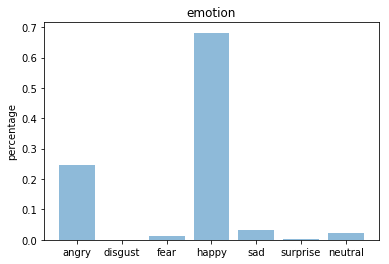

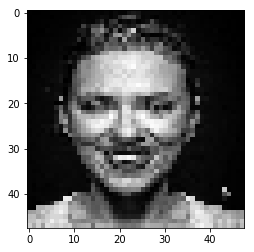

In [5]:
img = image.load_img("./happy.png", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255


custom = load_model.predict(x)
draw_emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
